
#  Federal Reserve v.s. European Central Bank

<img src="http://si.wsj.net/public/resources/images/BN-KI960_0917FE_G_20150917145339.jpg" width="350",style="float: left; margin: 50px">
<img src="http://cdn2.spectator.co.uk/files/2016/07/131243984.jpg" width="360",style="float: right; margin: 50px">

## Predicting:

> 1. Interest Rate Spread between US and EU (US_rate - GR_rate)
     - Regression: Spread Value
     - Binary Classification: US+ / GR+
     - Multiple Classification: US+ / Neutral / GR+
> 2. Currency Pair: EUR/USD
 
## Hypothesis:

> - Can textual data conveys additional information which is not presented in the 'baseline model'? (i.e. predict the residual of 'baseline model')

## Data Source

### 1. Offical RSS Feeds

> - FED RSS feeds: http://www.federalreserve.gov/feeds/

> - ECB RSS feeds: https://www.ecb.europa.eu/home/html/rss.en.html

### 2. Twitter API 

> - [Federal Reserve Twitter](https://twitter.com/federalreserve)

> - [ECB Twitter](https://twitter.com/ecb)

> - [Twitter Rest API](https://dev.twitter.com/rest/public)

### 3. Market Quotes Data

#### 3.1 Quandl
> - [Quandl API](https://www.quandl.com/docs/api) for market prices
 - [USA Interest Rates](https://www.quandl.com/collections/usa/usa-interest-rates)
 - [DEU Government Yield Curve](https://www.quandl.com/data/YC/DEU-German-Government-Yield-Curve)
 - [API for Interest Rate Data](https://blog.quandl.com/api-for-interest-rate-data)

#### 3.2 Bloomberg
> - [US Generic Govt 10 Year Yield: USGG10YR:IND](https://www.bloomberg.com/quote/USGG10YR:IND)
 - [Germany Generic Govt 10Y Yield: GDBR10:IND](https://www.bloomberg.com/quote/GDBR10:IND)

### 4. Other Press Release

> - FED: http://www.federalreserve.gov/newsevents/default.htm
 - ECB: https://www.ecb.europa.eu/press/pr/date/2016/html/index.en.html

## Data Dictionary

> - FOMC Statement: from Jan 2011 to Nov 2016 (8 times per year), in text format
> - FOMC Minutes: from Jan 2011 to Sep 2016 (8 times per year), in text format
     - UPDATE: [FOMC Corpus](http://stanford.edu/~rezab/useful/fomc_minutes.html): from 1967 to 2008
> - [ECB Monetary Policy Decision](https://www.ecb.europa.eu/press/govcdec/mopo/2016/html/index.en.html): to Oct 2016, in text format (not scraped yet)
> - US Govt 2 Year Yield, up to date (daily), float
> - GR Govt 2 Year Yield, **limit access 2010-2014**, float
     - UPDATE: GR Govt 2 Year Yield since 2000
> - S&P500 Stock Index, up to date (daily), float
> - Boerse AG German Stock Index, up to date (daily), float
> - EURUSD spot rate, up to date (daily), float
> - USA Inflation (CPI YoY): **monthly** since 1992, float
> - Germany Inflation (CPI YoY): **monthly** since 1992, float

## Reference

> 1. [Hanging on every word: Semantic analysis of the FOMC's postmeeting statement](https://www.federalreserve.gov/econresdata/notes/feds-notes/2015/semantic-analysis-of-the-FOMCs-postmeeting-statement-20150930.html)

> 2. [FOMC Minutes](http://rezab.ca/useful/fomc_minutes.html), maintained by [Adjunct Professor, Reza Zadeh](https://stanford.edu/~rezab/), at Stanford ICME

> 3. [How to download FOMC statements](https://mktstk.com/2015/03/20/how-to-download-fomc-statements/)

In [1]:
import twitter
import re
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('fivethirtyeight')
%matplotlib inline

In [2]:
twitter_keys = {
        'consumer_key': 'KEY'  ,
        'consumer_secret': 'SECRET' ,
        'access_token_key': 'KEY'  ,
        'access_token_secret': 'SECRET'
}

api = twitter.Api(
    consumer_key         =   twitter_keys['consumer_key'],
    consumer_secret      =   twitter_keys['consumer_secret'],
    access_token_key     =   twitter_keys['access_token_key'],
    access_token_secret  =   twitter_keys['access_token_secret']
)

In [3]:
class TwitterMiner():

    request_limit   =   15    
    api             =   False
    data            =   []
    
    twitter_keys = {
        'consumer_key': 'KEY'  ,
        'consumer_secret': 'SECRET' ,
        'access_token_key': 'KEY'  ,
        'access_token_secret': 'SECRET'
    }
    
    def __init__(self, request_limit = 20):
        
        self.request_limit = request_limit        
        # This sets the twitter API object for use internall within the class
        self.set_api()
        
    def set_api(self):
        
        self.api = twitter.Api(
            consumer_key = self.twitter_keys['consumer_key'],
            consumer_secret = self.twitter_keys['consumer_secret'],
            access_token_key = self.twitter_keys['access_token_key'],
            access_token_secret = self.twitter_keys['access_token_secret']
        )

    def mine_user_tweets(self, user, mine_rewteets=False, max_pages=5):

        data = []
        last_tweet_id = False
        page = 0
        
        while page <= max_pages:
            
            if last_tweet_id:
                statuses = self.api.GetUserTimeline(screen_name=user, count=self.request_limit, max_id=last_tweet_id - 1)        
            else:
                statuses = self.api.GetUserTimeline(screen_name=user, count=self.request_limit)
                
            for item in statuses:

                mined = {
                    'tweet_id': item.id,
                    'handle': item.user.name,
                    'retweet_count': item.retweet_count,
                    'text': item.text,
                    'mined_at': datetime.datetime.now(),
                    'created_at': item.created_at,
                }
                
                last_tweet_id = item.id
                data.append(mined)
                
            page += 1
        
        # return a list of dictionary
        return data

In [4]:
miner = TwitterMiner(request_limit=300)

fed = miner.mine_user_tweets(user="federalreserve", max_pages=10)
ecb = miner.mine_user_tweets(user="ecb", max_pages=10)

In [5]:
fed_df = pd.DataFrame(fed)
ecb_df = pd.DataFrame(ecb)
print fed_df.shape, ecb_df.shape

(2200, 6) (2200, 6)


In [6]:
fed_df.head()

,created_at,handle,mined_at,retweet_count,text,tweet_id
0,Thu Nov 03 20:31:28 +0000 2016,Federal Reserve,2016-11-03 23:47:41.410,7,Interactive guide to our weekly #BalanceSheet ...,794275827710095360
1,Thu Nov 03 20:31:10 +0000 2016,Federal Reserve,2016-11-03 23:47:41.410,8,Our weekly #BalanceSheet update: https://t.co/...,794275749654102017
2,Thu Nov 03 15:04:46 +0000 2016,Federal Reserve,2016-11-03 23:47:41.410,7,Today's #EnforcementAction: https://t.co/oBT63...,794193610157727744
3,Wed Nov 02 18:00:12 +0000 2016,Federal Reserve,2016-11-03 23:47:41.410,146,Federal Open Market Committee statement: https...,793875369522855937
4,Tue Nov 01 16:53:37 +0000 2016,Federal Reserve,2016-11-03 23:47:41.410,10,Today's #EnforcementAction: https://t.co/pmQet...,793496226712920064


In [7]:
ecb_df.head()

,created_at,handle,mined_at,retweet_count,text,tweet_id
0,Thu Nov 03 21:03:59 +0000 2016,ECB,2016-11-03 23:47:45.389,7,Cœuré: Safe government debt rests on adherence...,794284008951660544
1,Thu Nov 03 21:03:36 +0000 2016,ECB,2016-11-03 23:47:45.389,7,Cœuré: Further fiscal risk-sharing needs to be...,794283914009448448
2,Thu Nov 03 21:03:12 +0000 2016,ECB,2016-11-03 23:47:45.389,14,Cœuré: We need some form of fiscal risk-sharin...,794283813790683136
3,Thu Nov 03 21:02:42 +0000 2016,ECB,2016-11-03 23:47:45.389,13,Cœuré: Europe needs reforms to ensure that sov...,794283686216814592
4,Thu Nov 03 21:02:15 +0000 2016,ECB,2016-11-03 23:47:45.389,12,Cœuré: Euro area governments can make their de...,794283573603926016


In [8]:
ecb_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2200 entries, 0 to 2199
Data columns (total 6 columns):
created_at       2200 non-null object
handle           2200 non-null object
mined_at         2200 non-null datetime64[ns]
retweet_count    2200 non-null int64
text             2200 non-null object
tweet_id         2200 non-null int64
dtypes: datetime64[ns](1), int64(2), object(3)
memory usage: 103.2+ KB


In [9]:
print 'FED from', fed_df.created_at.values[-1], 'to', fed_df.created_at.values[0]
print 'ECB from', ecb_df.created_at.values[-1], 'to', ecb_df.created_at.values[0]

FED from Thu Sep 26 15:16:05 +0000 2013 to Thu Nov 03 20:31:28 +0000 2016
ECB from Thu Jul 30 08:07:44 +0000 2015 to Thu Nov 03 21:03:59 +0000 2016


In [10]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from collections import Counter

In [11]:
fed_vect = TfidfVectorizer(ngram_range=(2, 4), stop_words='english', min_df=0.05, max_df=0.95)
fed_vect.fit(fed_df.text)
fed_vect.vocabulary_

{u'assets liabilities': 0,
 u'assets liabilities commercial': 1,
 u'assets liabilities commercial banks': 2,
 u'available weekly': 3,
 u'available weekly data': 4,
 u'available weekly data assets': 5,
 u'balancesheet report': 6,
 u'balancesheet trends': 7,
 u'balancesheet update': 8,
 u'banks united': 9,
 u'banks united states': 10,
 u'chair yellen': 11,
 u'chart showing': 12,
 u'chart showing recent': 13,
 u'chart showing recent balancesheet': 14,
 u'commercial banks': 15,
 u'commercial banks united': 16,
 u'commercial banks united states': 17,
 u'data assets': 18,
 u'data assets liabilities': 19,
 u'data assets liabilities commercial': 20,
 u'date job': 21,
 u'date job postings': 22,
 u'date job postings ff': 23,
 u'fed_careers date': 24,
 u'fed_careers date job': 25,
 u'fed_careers date job postings': 26,
 u'federal reserve': 27,
 u'follow fed_careers': 28,
 u'follow fed_careers date': 29,
 u'follow fed_careers date job': 30,
 u'guide weekly': 31,
 u'guide weekly balancesheet': 32,


In [12]:
ecb_vect = CountVectorizer(ngram_range=(2, 4), stop_words='english', min_df=0.05, max_df=0.95)
ecb_vect.fit(fed_df.text)
ecb_vect.vocabulary_

{u'assets liabilities': 0,
 u'assets liabilities commercial': 1,
 u'assets liabilities commercial banks': 2,
 u'available weekly': 3,
 u'available weekly data': 4,
 u'available weekly data assets': 5,
 u'balancesheet report': 6,
 u'balancesheet trends': 7,
 u'balancesheet update': 8,
 u'banks united': 9,
 u'banks united states': 10,
 u'chair yellen': 11,
 u'chart showing': 12,
 u'chart showing recent': 13,
 u'chart showing recent balancesheet': 14,
 u'commercial banks': 15,
 u'commercial banks united': 16,
 u'commercial banks united states': 17,
 u'data assets': 18,
 u'data assets liabilities': 19,
 u'data assets liabilities commercial': 20,
 u'date job': 21,
 u'date job postings': 22,
 u'date job postings ff': 23,
 u'fed_careers date': 24,
 u'fed_careers date job': 25,
 u'fed_careers date job postings': 26,
 u'federal reserve': 27,
 u'follow fed_careers': 28,
 u'follow fed_careers date': 29,
 u'follow fed_careers date job': 30,
 u'guide weekly': 31,
 u'guide weekly balancesheet': 32,


In [13]:
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle

In [14]:
all_tweets = pd.DataFrame(fed + ecb)
all_vect = CountVectorizer(ngram_range=(2, 4), stop_words='english', max_df = 0.90, min_df = 0.01)

In [15]:
import string

to_be_removed = ['fed', 'ecb', 'benoît','cœuré', 'draghi', 'peter', 'praet','fischer', 'yellen']

def text_process(mess):
    mess = mess.lower()
    de_punc = ''.join([char for char in mess if char not in string.punctuation])
    return ' '.join(filter(lambda w: w not in to_be_removed, de_punc.split(' ')))

print all_tweets['text'][:5]

print all_tweets['text'].apply(text_process)[:5]

0    Interactive guide to our weekly #BalanceSheet ...
1    Our weekly #BalanceSheet update: https://t.co/...
2    Today's #EnforcementAction: https://t.co/oBT63...
3    Federal Open Market Committee statement: https...
4    Today's #EnforcementAction: https://t.co/pmQet...
Name: text, dtype: object


C:\toolkits\anaconda2-4.2.0\lib\site-packages\ipykernel\__main__.py:8: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal


0    interactive guide to our weekly balancesheet r...
1    our weekly balancesheet update httpstcoykkgejd...
2          todays enforcementaction httpstcoobt63rmmbp
3    federal open market committee statement httpst...
4          todays enforcementaction httpstcopmqetay1k5
Name: text, dtype: object


In [16]:
labels = LabelEncoder()
y = labels.fit_transform(all_tweets['handle'])
X = all_vect.fit_transform(all_tweets['text'].apply(text_process))
X_r, y_r = shuffle(X, y)

C:\toolkits\anaconda2-4.2.0\lib\site-packages\ipykernel\__main__.py:8: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal


In [17]:
all_vect.vocabulary_

{u'approval application': 0,
 u'assetbacked securities': 1,
 u'assetbacked securities cumulatively': 2,
 u'assetbacked securities cumulatively purchased': 3,
 u'assets cumulatively': 4,
 u'assets cumulatively purchased': 5,
 u'assets cumulatively purchased settled': 6,
 u'assets liabilities': 7,
 u'assets liabilities commercial': 8,
 u'assets liabilities commercial banks': 9,
 u'available weekly': 10,
 u'available weekly data': 11,
 u'available weekly data assets': 12,
 u'balancesheet report': 13,
 u'balancesheet trends': 14,
 u'balancesheet update': 15,
 u'banks united': 16,
 u'banks united states': 17,
 u'beno\xeet c\u0153ur\xe9': 18,
 u'board linkedin': 19,
 u'board linkedin uptodate': 20,
 u'board linkedin uptodate job': 21,
 u'board meeting': 22,
 u'bonds cumulatively': 23,
 u'bonds cumulatively purchased': 24,
 u'bonds cumulatively purchased settled': 25,
 u'bulletin box': 26,
 u'calendar events': 27,
 u'chart showing': 28,
 u'chart showing recent': 29,
 u'chart showing recent ba

In [18]:
labels.classes_

array([u'ECB', u'Federal Reserve'], dtype=object)

In [19]:
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV

In [20]:
logit = LogisticRegressionCV(penalty='l1',solver='liblinear',Cs=10,cv=10, n_jobs=-1)
logit.fit(X_r, y_r)

print logit.score(X_r, y_r)

0.799318181818


In [21]:
get_token = pd.DataFrame.from_dict(all_vect.vocabulary_,orient='index').sort_values(0).index

logit_coef = pd.DataFrame(np.ravel(logit.coef_), index=get_token, columns=['coeffient'])
logit_coef.sort_values('coeffient',inplace=True)

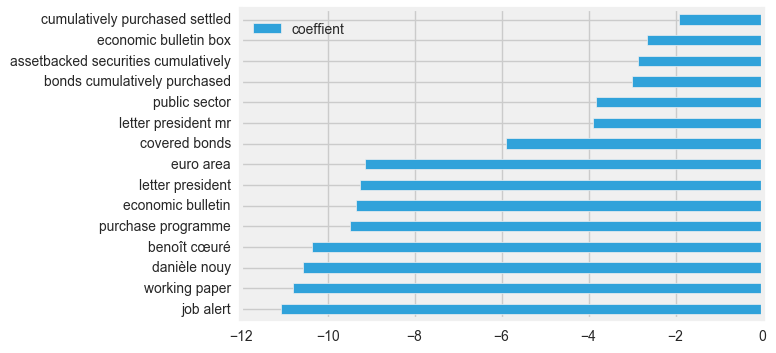

In [22]:
logit_coef.head(15).plot(kind='barh')

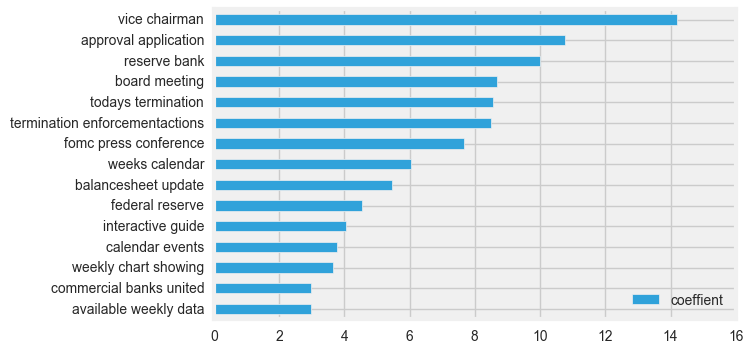

In [23]:
logit_coef.tail(15).plot(kind='barh')

### FOMC Meeting

In [24]:
from bs4 import BeautifulSoup as bs
#import requests
import urllib2
import nltk
from nltk import word_tokenize
from nltk.collocations import *

In [25]:
from scrapy.selector import Selector
url = 'https://www.federalreserve.gov/monetarypolicy/fomccalendars.htm'

response = urllib2.urlopen(url)
html = response.read()

In [26]:
# mth_e = Selector(text=html).xpath('//tr[@class="even"]/td[@class="month"]/text()').extract()
# day_e = Selector(text=html).xpath('//tr[@class="even"]/td[@class="day"]/text()').extract()
# url_e = Selector(text=html).xpath('//tr[@class="even"]/td[@class="minutes"]/a[text()="HTML"]/@href').extract()
# rls_e = Selector(text=html).xpath('//tr[@class="even"]/td[@class="minutes"]/text()[4]').extract()

# mth_o = Selector(text=html).xpath('//tr[@class="odd"]/td[@class="month"]/text()').extract()
# day_o = Selector(text=html).xpath('//tr[@class="odd"]/td[@class="day"]/text()').extract()
# url_o = Selector(text=html).xpath('//tr[@class="odd"]/td[@class="minutes"]/a[text()="HTML"]/@href').extract()
# rls_o = Selector(text=html).xpath('//tr[@class="odd"]/td[@class="minutes"]/text()[4]').extract()

# print Selector(text=html).xpath('//tr[@class="even"]/td[@class="statement2"]/a[text()="HTML"]/@href').extract()
# print Selector(text=html).xpath('//tr[@class="odd"]/td[@class="statement2"]/a[text()="HTML"]/@href').extract()

In [27]:
mth = Selector(text=html).xpath('//td[@class="month"]/text()').extract()
day = Selector(text=html).xpath('//td[@class="day"]/text()').extract()
url = Selector(text=html).xpath('//td[@class="minutes"]/a[text()="HTML"]/@href').extract()
rls = Selector(text=html).xpath('//td[@class="minutes"]/text()[4]').extract()

print map(len, [mth, day, url, rls])

[60, 60, 46, 46]


In [28]:
statement_url_1 = Selector(text=html).xpath('//td[@class="statement2"]/a[text()="HTML"]/@href').extract()
statement_url_2 = Selector(text=html).xpath('//td[@class="statement2"]/a[text()="Statement"]/@href').extract()
minutes_url = Selector(text=html).xpath('//td[@class="minutes"]/a[text()="HTML"]/@href').extract()
statement_url = statement_url_1 + statement_url_2

In [29]:
print len(statement_url), len(minutes_url)

47 46


In [33]:
# statement: https://www.federalreserve.gov/newsevents/press/monetary/20160921a.htm
stmt = {re.findall('[0-9]+' ,url)[0]: 'https://www.federalreserve.gov' + url for url in statement_url}

# minutes: https://www.federalreserve.gov/monetarypolicy/fomcminutes20160921.htm
mins = {re.findall('[0-9]+' ,url)[0]: 'https://www.federalreserve.gov' + url for url in minutes_url}

In [37]:
mins

{u'20110126': u'https://www.federalreserve.gov/monetarypolicy/fomcminutes20110126.htm',
 u'20110315': u'https://www.federalreserve.gov/monetarypolicy/fomcminutes20110315.htm',
 u'20110427': u'https://www.federalreserve.gov/monetarypolicy/fomcminutes20110427.htm',
 u'20110622': u'https://www.federalreserve.gov/monetarypolicy/fomcminutes20110622.htm',
 u'20110809': u'https://www.federalreserve.gov/monetarypolicy/fomcminutes20110809.htm',
 u'20110921': u'https://www.federalreserve.gov/monetarypolicy/fomcminutes20110921.htm',
 u'20111102': u'https://www.federalreserve.gov/monetarypolicy/fomcminutes20111102.htm',
 u'20111213': u'https://www.federalreserve.gov/monetarypolicy/fomcminutes20111213.htm',
 u'20120125': u'https://www.federalreserve.gov/monetarypolicy/fomcminutes20120125.htm',
 u'20120313': u'https://www.federalreserve.gov/monetarypolicy/fomcminutes20120313.htm',
 u'20120425': u'https://www.federalreserve.gov/monetarypolicy/fomcminutes20120425.htm',
 u'20120620': u'https://www.fede

In [44]:


def get_fomc_doc(doc_url):
    res = urllib2.urlopen(doc_url)
    res = res.read()
    soup = bs(res, 'html.parser')
    statement = soup.find('div', attrs={'id': 'leftText'})
    paragraphs = [paragraph.text.strip() for paragraph in statement.findAll('p')[1:-1]]
    
    return '\n'.join(paragraphs)

In [61]:
from textblob import TextBlob
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from nltk.corpus import stopwords
en_stopwords = stopwords.words('english')

def split_into_lemmas(message):

    words = TextBlob(message.lower().replace("'",' ')).words
    words = [word.lemma for word in words]
    return ' '.join(filter(lambda w: w not in en_stopwords, words))

In [62]:
split_into_lemmas(get_fomc_doc('https://www.federalreserve.gov/monetarypolicy/fomcminutes20160427.htm'))

u'charles l evans patrick harker robert kaplan neel kashkari michael strine alternate member federal open market committee jeffrey lacker dennis p lockhart john c williams president federal reserve bank richmond atlanta san francisco respectively brian f madigan secretary matthew luecke deputy secretary david w skidmore assistant secretary michelle smith assistant secretary scott g alvarez general counsel thomas c baxter deputy general counsel steven b kamin economist thomas laubach economist david w wilcox economist thomas connors troy davig michael p leahy david e lebow stephen meyer geoffrey tootell william wascher associate economist simon potter manager system open market account lorie k logan deputy manager system open market account robert dev frierson secretary board office secretary board governor michael gibson director division banking supervision regulation board governor nellie liang director office financial stability policy research board governor james clouse deputy dir

In [63]:
fomc_doc = {
    'date': [],
    'type': [],
    'text': []    
}

for stmt_date in stmt:
    fomc_doc['date'].append(stmt_date)
    fomc_doc['type'].append('statement')
    fomc_doc['text'].append(get_fomc_doc(stmt[stmt_date]))

for mins_date in mins:
    fomc_doc['date'].append(mins_date)
    fomc_doc['type'].append('minutes')
    fomc_doc['text'].append(get_fomc_doc(mins[mins_date]))

In [64]:
fomc = pd.DataFrame.from_dict(fomc_doc).sort_values('date').reset_index()
del fomc['index']
fomc.head()

,date,text,type
0,20110126,Information received since the Federal Open Ma...,statement
1,20110126,"Jeffrey M. Lacker, Dennis P. Lockhart, John F....",minutes
2,20110315,Information received since the Federal Open Ma...,statement
3,20110315,"Jeffrey M. Lacker, Dennis P. Lockhart, Sandra ...",minutes
4,20110427,"Christine Cumming, Jeffrey M. Lacker, Dennis P...",minutes


In [72]:
#tfv = TfidfTransformer().fit(fomc.text)

all_fomc_text = fomc.text.apply(split_into_lemmas)
cv = CountVectorizer(ngram_range=(1,3), max_df=0.75, min_df=0.05, stop_words='english')
cv.fit(all_fomc_text)

print len(cv.vocabulary_)

15456


In [68]:
cv.vocabulary_

{u'joyce zickler': 7430,
 u'stable total nonfarm': 13643,
 u'consistent objective': 2735,
 u'wednesday': 15194,
 u'continued strengthen': 2969,
 u'realized expected objective': 11699,
 u'quarter data': 11259,
 u'unemployment inflation': 14717,
 u'pointed additional': 10404,
 u'depend assessment': 3634,
 u'governor lawrence slifman': 5908,
 u'board governor lawrence': 1571,
 u'ioer': 7275,
 u'senior associate director': 13025,
 u'25 billion purpose': 181,
 u'indicating committee': 6788,
 u'add holding': 466,
 u'policy accommodation balanced': 10422,
 u'market expectation': 8335,
 u'ahead committee': 689,
 u'paid received connection': 9884,
 u'needed': 9168,
 u'good declined': 5812,
 u'respect foreign': 12311,
 u'meeting participant discussed': 8612,
 u'trading range percent': 14504,
 u'outlook informed': 9721,
 u'bank announced': 1332,
 u'accompanied weak': 311,
 u'preceding quarter': 10643,
 u'tech': 14195,
 u'cost index rose': 3085,
 u'esther george eric': 4638,
 u'secretary david ski

In [74]:
X = cv.fit_transform(all_fomc_text)
vocab = {v: k for k, v in cv.vocabulary_.iteritems()}

In [75]:
from collections import defaultdict
from gensim import corpora, models, matutils

def get_gensim_dict_corpus(documents):
    frequency = defaultdict(int)
    
    selected_w = cv.get_feature_names()
    filtered_doc = [filter(lambda w: w in selected_w, doc.split(' ')) for doc in documents]

    for text in filtered_doc:
        for token in text:
            frequency[token] += 1

    texts = [[token for token in text if frequency[token] > 1] for text in filtered_doc]
    dictionary = corpora.Dictionary(texts)
    corpus = [dictionary.doc2bow(text) for text in texts]
    
    return dictionary, corpus

In [76]:
dictionary_fomc, corpus_fomc = get_gensim_dict_corpus(all_fomc_text)

In [77]:
lda = models.LdaModel(matutils.Sparse2Corpus(X, documents_columns=False), num_topics = 5, id2word = vocab, passes = 20)

In [78]:
lda.print_topics(num_topics=5, num_words=8)

[(0,
  u'0.005*economic recovery + 0.003*maturity + 0.003*low level federal + 0.003*level federal fund + 0.003*exceptionally low level + 0.003*level federal + 0.003*program + 0.003*exceptionally'),
 (1,
  u'0.007*participant + 0.004*asset + 0.004*period + 0.003*meeting + 0.003*asset purchase + 0.003*bank + 0.002*board + 0.002*reserve'),
 (2,
  u'0.004*asset purchase + 0.004*asset + 0.003*goal + 0.003*billion + 0.003*billion month + 0.002*run goal + 0.002*longer run goal + 0.002*balanced'),
 (3,
  u'0.008*participant + 0.005*bank + 0.004*quarter + 0.004*period + 0.004*consumer + 0.003*meeting + 0.003*reserve + 0.003*board'),
 (4,
  u'0.007*participant + 0.004*board + 0.004*bank + 0.004*foreign + 0.004*quarter + 0.003*period + 0.003*reserve + 0.003*governor')]

In [90]:
for top_topic in lda.top_topics(corpus_fomc):
    for topic in map(lambda ele: (round(ele[0], 5), ele[1]), top_topic[0]):
        print topic
    print '\n'

(0.00452, u'economic recovery')
(0.00308, u'maturity')
(0.00286, u'low level federal')
(0.00286, u'level federal fund')
(0.00286, u'exceptionally low level')
(0.00286, u'level federal')
(0.00285, u'program')
(0.00284, u'exceptionally')
(0.00284, u'exceptionally low')
(0.00281, u'stronger economic recovery')
(0.0028, u'stronger economic')
(0.00279, u'quarter')
(0.00274, u'low level')
(0.00271, u'level consistent')
(0.00265, u'ensure')
(0.00264, u'help ensure')
(0.00264, u'help ensure inflation')
(0.00264, u'economic recovery help')
(0.00264, u'recovery help ensure')
(0.00264, u'recovery help')


(0.00763, u'participant')
(0.00471, u'bank')
(0.0041, u'quarter')
(0.00404, u'period')
(0.00354, u'consumer')
(0.00331, u'meeting')
(0.00324, u'reserve')
(0.0031, u'board')
(0.00286, u'federal reserve')
(0.00261, u'member')
(0.00252, u'noted')
(0.00246, u'governor')
(0.00245, u'real')
(0.00241, u'board governor')
(0.00241, u'credit')
(0.00233, u'intermeeting')
(0.00232, u'loan')
(0.00226, u'inte

In [92]:
topics_labels= {
    0: "Low Level Rates Eco",
    1: "FED",
    2: "Foreign Currency",
    3: "Asset Purchase",
    4: "Employment Inflation"
}

In [95]:
doc_topics = [lda.get_document_topics(doc) for doc in corpus_fomc]
topic_data = []

for document_id, topics in enumerate(doc_topics):
    
    document_topics = []
    for topic, probability in topics:
        topic_data.append({'document_id': document_id, 'topic': topics_labels[topic], 'probability': probability})

topics_df = pd.DataFrame(topic_data)

topic_post = topics_df.pivot_table(values='probability', columns='topic', index="document_id")
topic_post.reset_index()
topic_post.index.name = None
topic_post.columns.name = None
topic_post.fillna(0, inplace=True)

In [98]:
print fomc.shape, topic_post.shape

 (93, 3) (93, 5)


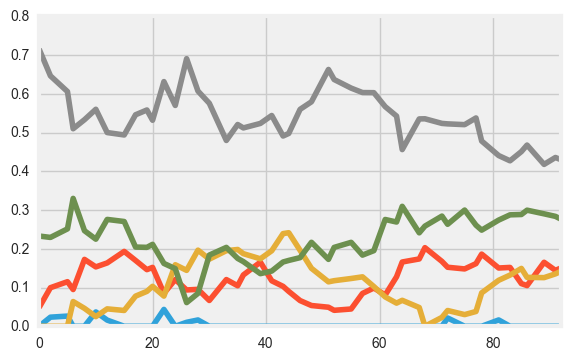

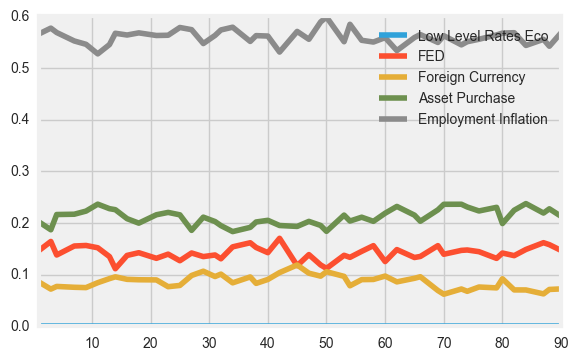

In [106]:
fomc_w_topic = pd.concat([fomc, topic_post], axis=1)
ax1 = fomc_w_topic[fomc_w_topic['type'] == 'statement'][topics_labels.values()].plot(legend=False)
ax2 = fomc_w_topic[fomc_w_topic['type'] == 'minutes'][topics_labels.values()].plot(legend=False)

patches, labels = ax1.get_legend_handles_labels()
#ax1.legend(patches, labels, loc='upper center')

patches, labels = ax2.get_legend_handles_labels()
#ax2.legend(patches, labels, loc='upper center')
plt.legend()

In [25]:
def get_fomc_paragraphs(url):
    res = urllib2.urlopen(url)
    res = res.read()
    soup = bs(res, 'html.parser')
    statement = soup.find('div', attrs={'id': 'leftText'})
    paragraphs = statement.findAll('p')[1:-1]
    
    speech = []
    for paragraph in paragraphs:
        tokens = word_tokenize(paragraph.text.strip())
        speech.append(tokens)
 
    speech = np.concatenate(speech, axis = 0)
    text = nltk.Text(speech)
    
    return text.collocations()

In [26]:
# FOMC July 2016
url = 'https://www.federalreserve.gov/monetarypolicy/fomcminutes20160727.htm'
get_fomc_paragraphs(url)

federal funds; labor market; intermeeting period; funds rate; monetary
policy; second quarter; Federal Reserve; energy prices; little
changed; target range; interest rates; New York; Open Market; Brexit
vote; Monetary Affairs; earlier declines; economic activity; Treasury
securities; United Kingdom; mortgage-backed securities


In [27]:
# FOMC September 2016
url = 'https://www.federalreserve.gov/monetarypolicy/fomcminutes20160921.htm'
get_fomc_paragraphs(url)

federal funds; funds rate; labor market; target range; monetary
policy; Federal Reserve; intermeeting period; third quarter;
unemployment rate; recent months; Open Market; little changed;
Monetary Affairs; inflation expectations; real GDP; mortgage-backed
securities; longer-run normal; Reserve Bank; energy prices; agency
mortgage-backed


# Quandl API

In [107]:
import quandl as qd

qd_Key = 'MY_KEY'
qd.ApiConfig.api_key = qd_Key

s_date = '2010-01-01'
e_date = '2015-01-31'

In [108]:
# World Bank data from Quandl
# https://www.quandl.com/data/WGEM-World-Bank-Global-Economic-Monitor/documentation/documentation
# WGEM/{COUNTRY}_{INDICATOR}
# United States|USA
# Germany|DEU

# CPTOTSAXNZGY

In [109]:
SPX = qd.get("YAHOO/INDEX_GSPC", start_date=s_date, end_date=e_date).Close
DAX = qd.get("YAHOO/INDEX_GDAXI", start_date=s_date, end_date=e_date).Close

print SPX.index.min(), SPX.index.max()
print DAX.index.min(), DAX.index.max()

2010-01-04 00:00:00 2015-01-30 00:00:00
2010-01-04 00:00:00 2015-01-30 00:00:00


In [110]:
US_Inf = qd.get("RATEINF/INFLATION_USA", start_date=s_date, end_date=e_date)
GR_Inf = qd.get("RATEINF/INFLATION_DEU", start_date=s_date, end_date=e_date)

print US_Inf.index.min(), US_Inf.index.max()
print GR_Inf.index.min(), GR_Inf.index.max()

2010-01-31 00:00:00 2015-01-31 00:00:00
2010-01-31 00:00:00 2015-01-31 00:00:00


In [111]:
EURUSD = qd.get('FED/RXI_US_N_B_EU', start_date=s_date, end_date=e_date)
print EURUSD.index.min(), EURUSD.index.max()

2010-01-04 00:00:00 2015-01-30 00:00:00


In [112]:
US2Y = qd.get("USTREASURY/YIELD", start_date=s_date, end_date=e_date)['2 YR'] # collapse="monthly"
GR2Y = qd.get("YC/DEU", start_date=s_date, end_date=e_date)['2-Year']

print US2Y.index.min(), US2Y.index.max()
print GR2Y.index.min(), GR2Y.index.max() # limited access

2010-01-04 00:00:00 2015-01-30 00:00:00
2010-01-04 00:00:00 2014-12-30 00:00:00


In [113]:
mkt_data = pd.concat([SPX, DAX, US_Inf, GR_Inf, EURUSD, US2Y, GR2Y], axis=1)
mkt_data = mkt_data.ix[:GR2Y.index.max(), :]
mkt_data.columns = ['SPX', 'DAX', 'USInf', 'GRInf', 'EURUSD', 'US2Y', 'GR2Y']
mkt_data.fillna(method='ffill',inplace=True)

data = pd.concat([mkt_data[['SPX', 'DAX', 'EURUSD']].pct_change(), (mkt_data.US2Y - mkt_data.GR2Y).shift(7), mkt_data],
                 axis=1).dropna()
data.columns = ['SPX_chg', 'DAX_chg', 'EURUSD_chg', 'lw_spread'] + mkt_data.columns.tolist()

data['time'] = map(lambda td: int(td.days), (data.index - data.index.min()))

# reorder columns
other_col = data.columns[:-1].tolist()
data = data[['time'] + other_col]

data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1292 entries, 2010-01-31 to 2014-12-30
Data columns (total 12 columns):
time          1292 non-null int64
SPX_chg       1292 non-null float64
DAX_chg       1292 non-null float64
EURUSD_chg    1292 non-null float64
lw_spread     1292 non-null float64
SPX           1292 non-null float64
DAX           1292 non-null float64
USInf         1292 non-null float64
GRInf         1292 non-null float64
EURUSD        1292 non-null float64
US2Y          1292 non-null float64
GR2Y          1292 non-null float64
dtypes: float64(11), int64(1)
memory usage: 131.2 KB


In [114]:
data.tail()

,time,SPX_chg,DAX_chg,EURUSD_chg,lw_spread,SPX,DAX,USInf,GRInf,EURUSD,US2Y,GR2Y
Date,,,,,,,,,,,,
2014-12-23,1787,0.001746,0.005712,-0.005877,0.60,2082.169922,9922.110352,1.322,0.6,1.2180,0.73,-0.09
2014-12-24,1788,-0.000139,0.000000,0.000657,0.65,2081.879883,9922.110352,1.322,0.6,1.2188,0.73,-0.09
2014-12-26,1790,0.003310,0.000000,0.000000,0.64,2088.770020,9922.110352,1.322,0.6,1.2188,0.73,-0.09
2014-12-29,1793,0.000862,0.000506,-0.000738,0.69,2090.570068,9927.129883,1.322,0.6,1.2179,0.72,-0.09
2014-12-30,1794,-0.004889,-0.012247,-0.000411,0.75,2080.350098,9805.549805,1.322,0.6,1.2174,0.69,-0.10


## Linear Regression & Autoregression

In [115]:
X = data.ix[:, :-2]
y = data.ix[:, -2] - data.ix[:, -1]

print X.shape, y.shape

(1292, 10) (1292L,)


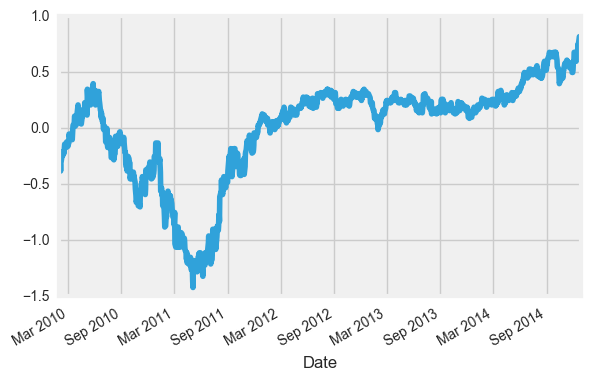

In [116]:
y.plot()

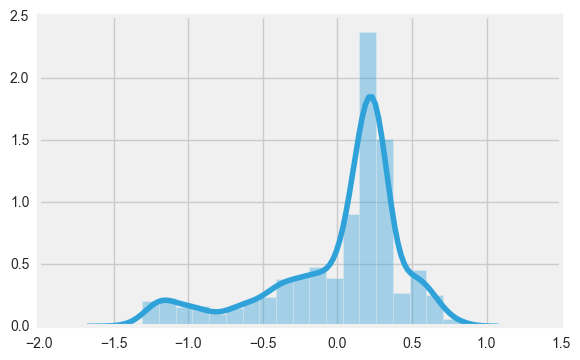

In [117]:
sns.distplot(y, bins=20)

In [118]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold

In [119]:
SS = StandardScaler()
Z = SS.fit_transform(X)

kf = KFold(n_splits=10, shuffle=True)
model = LinearRegression()
score = []

for train_index, test_index in kf.split(Z):
    
    Z_train, Z_test = Z[train_index], Z[test_index]
    y_train, y_test = y[train_index], y[test_index]
    model.fit(Z_train, y_train)
    score.append(model.score(Z_test, y_test))

print np.mean(score)
print score

0.964923350706
[0.95029871395872023, 0.95125303807152428, 0.9745100571286528, 0.9644978863389212, 0.97279943649304013, 0.9626234791178081, 0.96527614528533467, 0.96541850731699097, 0.97500978970534591, 0.96754645364328784]


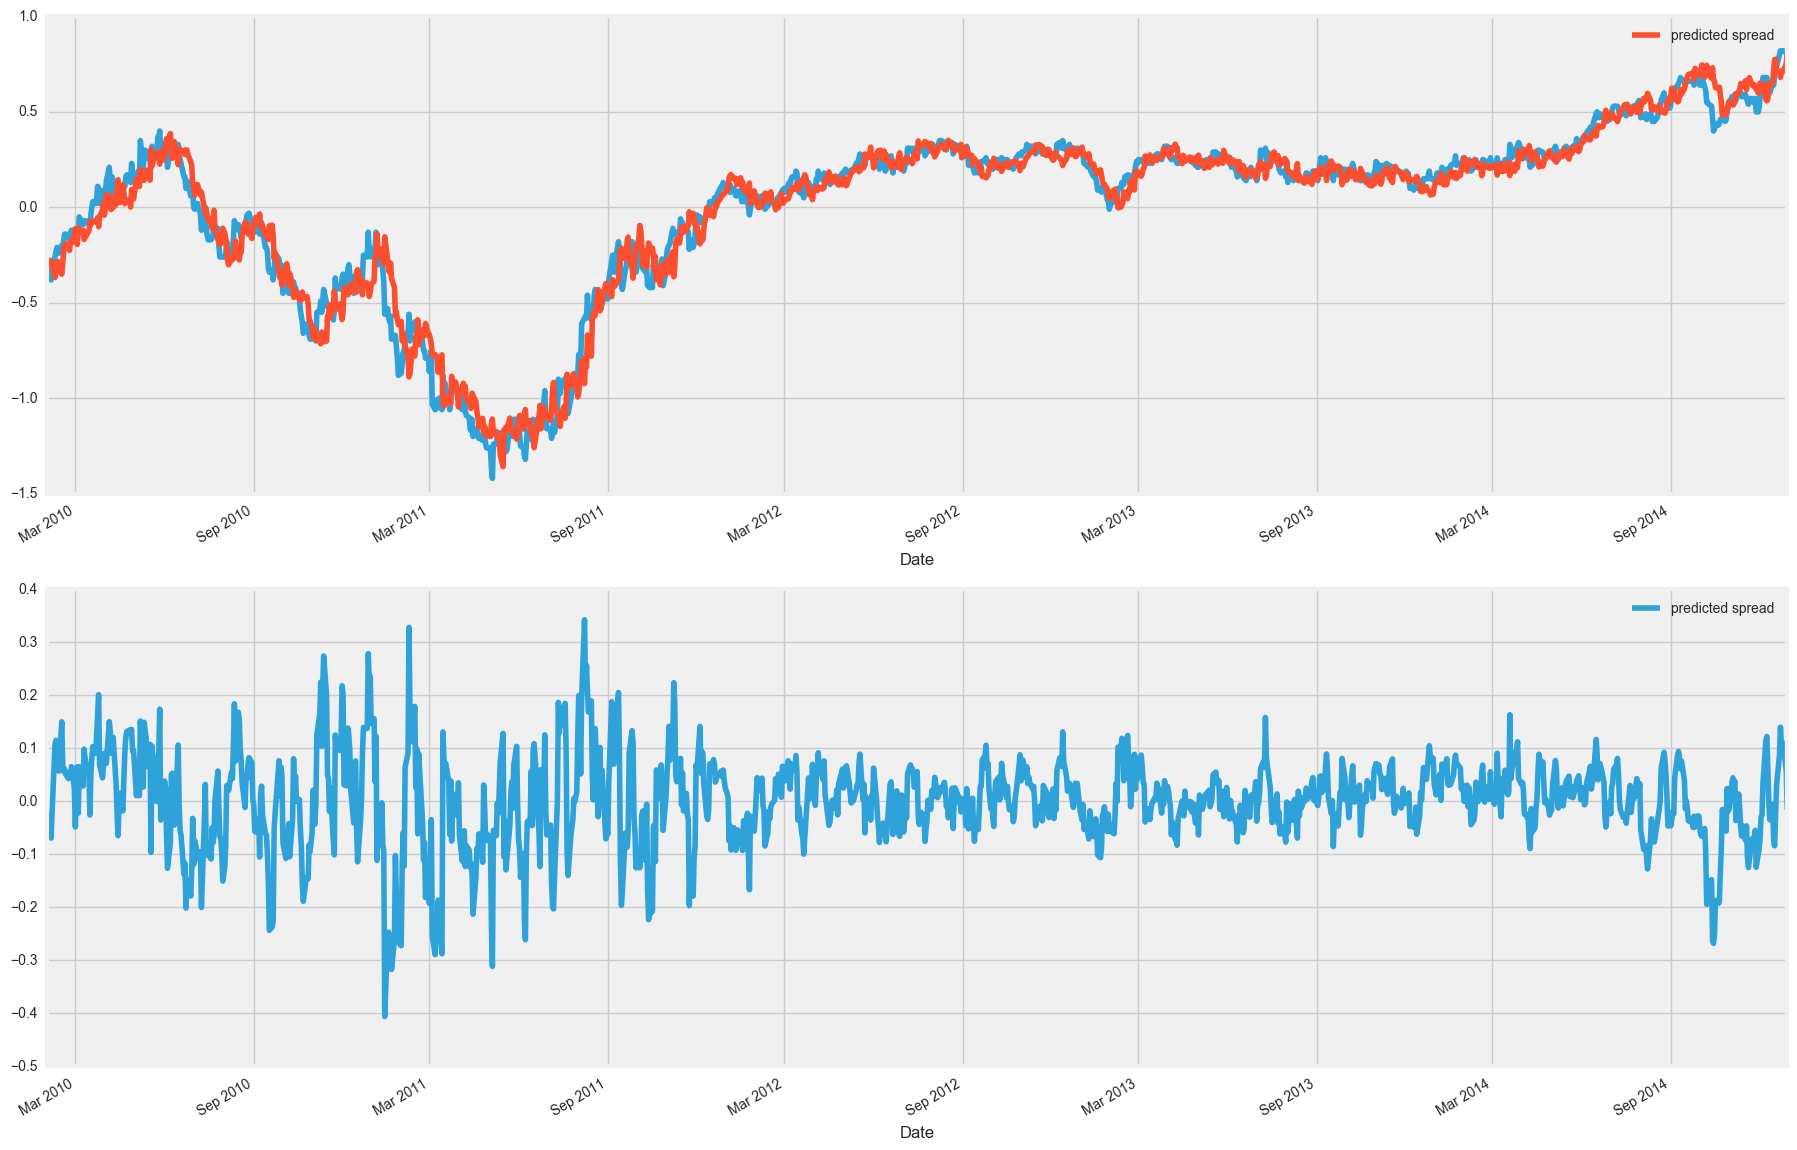

In [120]:
y_pred = model.predict(Z)

f, (ax1, ax2) = plt.subplots(2, 1, figsize=(20,15))
y.plot(ax=ax1, label='actual spread')
pd.DataFrame(y_pred, index=y.index, columns=['predicted spread']).plot(ax=ax1,label=['predict spread'])

pd.DataFrame(y - y_pred, index=y.index, columns=['predicted spread']).plot(ax=ax2,label=['residual'])
plt.legend()

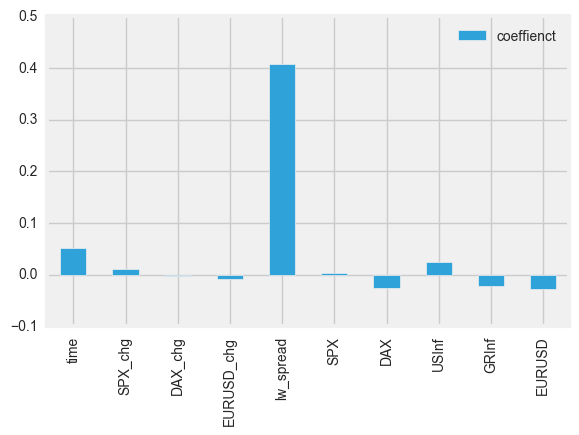

In [121]:
pd.DataFrame(model.coef_, index=X.columns, columns=['coeffienct']).plot(kind='bar')

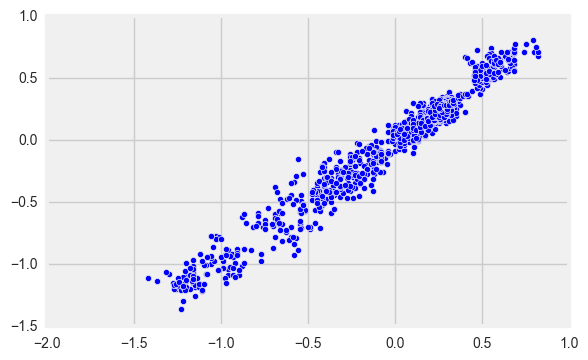

In [122]:
plt.scatter(y, y_pred)

## Classification: Spread widening or tightening

In [123]:
mkt_data.tail()

,SPX,DAX,USInf,GRInf,EURUSD,US2Y,GR2Y
Date,,,,,,,
2014-12-23,2082.169922,9922.110352,1.322,0.6,1.2180,0.73,-0.09
2014-12-24,2081.879883,9922.110352,1.322,0.6,1.2188,0.73,-0.09
2014-12-26,2088.770020,9922.110352,1.322,0.6,1.2188,0.73,-0.09
2014-12-29,2090.570068,9927.129883,1.322,0.6,1.2179,0.72,-0.09
2014-12-30,2080.350098,9805.549805,1.322,0.6,1.2174,0.69,-0.10


In [124]:
data_clf = mkt_data.dropna().copy()

data_clf['us_widen'] = ((data_clf.US2Y - data_clf.GR2Y).shift(-7) > (data_clf.US2Y - data_clf.GR2Y)).apply(int)
data_clf = data_clf.ix[:-7,:]

data_clf = pd.concat([data_clf[['SPX', 'DAX', 'EURUSD']].pct_change(), data_clf], axis=1).dropna()
data_clf.columns = ['SPX_chg', 'DAX_chg', 'EURUSD_chg'] + mkt_data.columns.tolist() + ['us_widen']

data_clf['time'] = map(lambda td: int(td.days), (data_clf.index - data_clf.index.min()))

# reorder columns
other_col = data_clf.columns[:-1].tolist()
data_clf = data_clf[['time'] + other_col]

data_clf.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1284 entries, 2010-02-01 to 2014-12-18
Data columns (total 12 columns):
time          1284 non-null int64
SPX_chg       1284 non-null float64
DAX_chg       1284 non-null float64
EURUSD_chg    1284 non-null float64
SPX           1284 non-null float64
DAX           1284 non-null float64
USInf         1284 non-null float64
GRInf         1284 non-null float64
EURUSD        1284 non-null float64
US2Y          1284 non-null float64
GR2Y          1284 non-null float64
us_widen      1284 non-null int64
dtypes: float64(10), int64(2)
memory usage: 130.4 KB


In [125]:
X = data_clf.ix[:,:-1]
y = data_clf.ix[:,-1]

0.531931464174


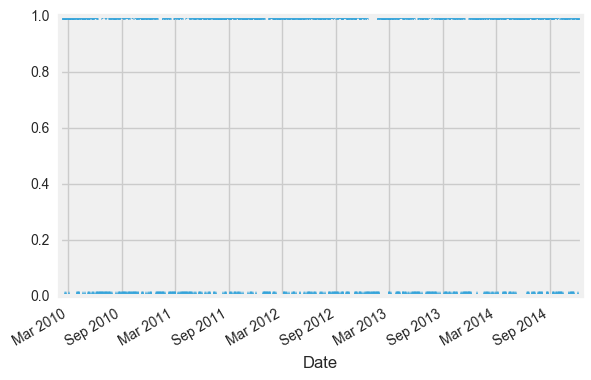

In [126]:
print y.mean()
y.plot(ls=' ', marker='*')

C:\toolkits\anaconda2-4.2.0\lib\site-packages\seaborn\matrix.py:143: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
  if xticklabels == []:
C:\toolkits\anaconda2-4.2.0\lib\site-packages\seaborn\matrix.py:151: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
  if yticklabels == []:


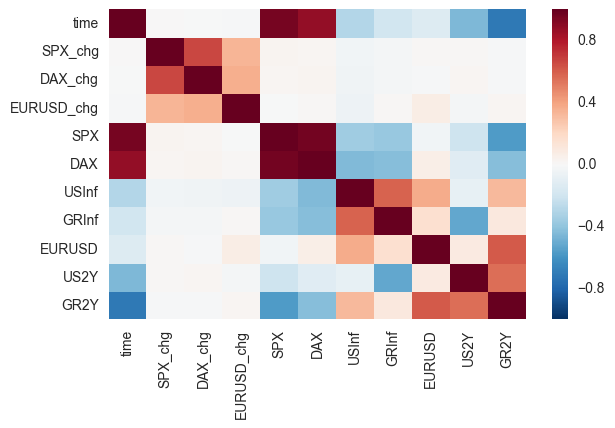

In [133]:
sns.heatmap(X.corr())

In [127]:
from sklearn.linear_model import LogisticRegression

In [128]:
SS = StandardScaler()
Z = SS.fit_transform(X)

kf = KFold(n_splits=10, shuffle=True)
model = LogisticRegression()
score = []

for train_index, test_index in kf.split(Z):
    
    Z_train, Z_test = Z[train_index], Z[test_index]
    y_train, y_test = y[train_index], y[test_index]
    model.fit(Z_train, y_train)
    score.append(model.score(Z_test, y_test))

print np.mean(score)
print score

0.588687015504
[0.62790697674418605, 0.63565891472868219, 0.60465116279069764, 0.61240310077519378, 0.59375, 0.5703125, 0.5703125, 0.6171875, 0.53125, 0.5234375]


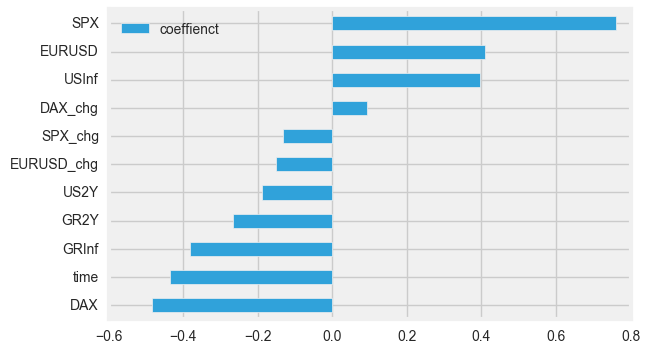

In [132]:
pd.DataFrame(model.coef_.T, index=X.columns, columns=['coeffienct']).sort_values('coeffienct').plot(kind='barh')

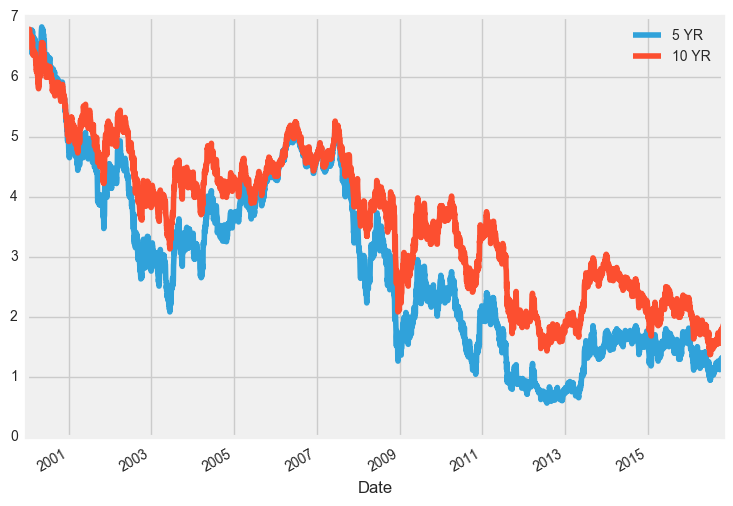

In [34]:
US_YC.fillna(method='ffill',inplace=True)
US_YC[['5 YR', '10 YR']].plot(figsize=(8, 6))

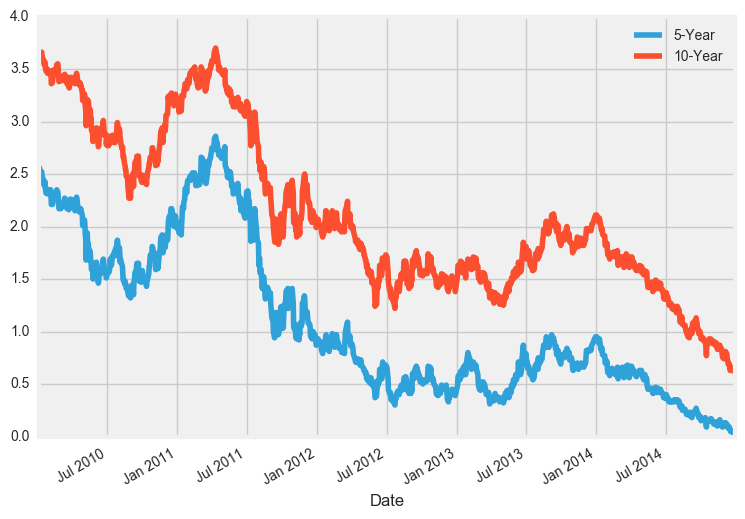

In [35]:
GR_YC.fillna(method='ffill',inplace=True)
GR_YC[['5-Year', '10-Year']].plot(figsize=(8, 6))